In [1]:
from utils import *
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda:0


In [ ]:
drive_dir = "/content/drive/MyDrive/OCT PVD/ZhangLabData/"
drive_dir = "/content/"
drive_dir = "data/OCT2017/"

# Original split
train_dir = drive_dir + "train/"
test_dir = drive_dir + "test/"

# Custom split
train_dir = drive_dir + "new_split/train/"
val_dir = drive_dir + "new_split/val/"
test_dir = drive_dir + "new_split/test/"

# Whitecropped custom split
train_dir = drive_dir + "cropped/train/"
val_dir = drive_dir + "cropped/val/"
test_dir = drive_dir + "cropped/test/"

### Optional - Patient ID based split

In [8]:
# # NEW 60-40 split on train data based on patient ID

# import os
# import shutil
# import random

# # Set random seed for reproducibility
# random.seed(42)

# # Directory containing class folders (CNV, DME, DRUSEN, NORMAL)
# source_dir = drive_dir+"CellData/OCT/new/"

# # List of class folders
# classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# # Create train and test directories
# train_dir = source_dir+'./train'
# test_dir = source_dir+'./test'

# # Ensure the train and test folders exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Create subfolders for each class inside train and test directories
# for class_name in classes:
#     os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
#     os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# # Function to split images based on patient IDs
# def split_images():
#     for class_name in classes:
#         class_folder = os.path.join(source_dir, class_name)
        
#         # Collect all image files for this class
#         image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpeg')]
        
#         # Get the patient IDs for this class
#         patient_ids = set(f.split('-')[1] for f in image_files)
        
#         # Randomly split the patient IDs into train and test sets (60% train, 40% test)
#         train_patient_ids = set(random.sample(patient_ids, int(0.6 * len(patient_ids))))
#         test_patient_ids = patient_ids - train_patient_ids
        
#         # Move files based on patient ID split
#         for image_file in image_files:
#             patient_id = image_file.split('-')[1]
#             src_path = os.path.join(class_folder, image_file)
            
#             if patient_id in train_patient_ids:
#                 dest_dir = os.path.join(train_dir, class_name)
#             else:
#                 dest_dir = os.path.join(test_dir, class_name)
            
#             dest_path = os.path.join(dest_dir, image_file)
#             shutil.move(src_path, dest_path)
#             print(f'Moved: {src_path} -> {dest_path}')

# # Run the image splitting function
# split_images()

# print("Image splitting complete!")


### Optional - removing white crop

In [13]:
from PIL import Image

output_dir = drive_dir + "cropped/train/"
def mask_white_space(image_path, save_path, white_threshold=245):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Detect white areas
    mask = cv2.inRange(img, white_threshold, 255)
    # Morphological operations to remove small white spots (optional)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Invert mask to keep the content and ignore white spaces
    inverted_mask = cv2.bitwise_not(mask)
    # Apply the mask to the original image to remove white areas
    result = cv2.bitwise_and(img, img, mask=inverted_mask)
    # Save the result as an image
    result_pil = Image.fromarray(result)
    result_pil.save(save_path)
# output_dir = "cropped/train/"
classes = ['DME', 'DRUSEN', 'NORMAL']

for folder in classes:
    input_folder = Path(train_dir+folder)
    output_folder = Path(output_dir+folder)
    output_folder.mkdir(exist_ok=True, parents=True)

    # Process each image in the folder
    for image_path in input_folder.glob("*.jpeg"):  # Use *.jpg or other format if needed
        save_path = output_folder / image_path.name
        mask_white_space(str(image_path), str(save_path))



In [17]:
output_dir = drive_dir + "cropped/test/"
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

for folder in classes:
    input_folder = Path(test_dir+folder)
    output_folder = Path(output_dir+folder)
    output_folder.mkdir(exist_ok=True, parents=True)

    # Process each image in the folder
    for image_path in input_folder.glob("*.jpeg"):  # Use *.jpg or other format if needed
        save_path = output_folder / image_path.name
        mask_white_space(str(image_path), str(save_path))


### Data Loading

In [19]:
class_dirs = {
    'CNV': train_dir+'/CNV',
    'DME': train_dir+'/DME',
    'DRUSEN': train_dir+'/DRUSEN',
    'NORMAL': train_dir+'/NORMAL'
}

# Initialize a dictionary to store the patient counts and image counts per patient for each class
patient_counts = defaultdict(int)  # To store the number of patients per class
images_per_patient = defaultdict(lambda: defaultdict(int))  # To store the number of images per patient per class

# Loop through each class directory
for class_name, class_dir in class_dirs.items():
    # Get all image files in the class folder
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpeg')]
    
    # For each image, extract the patient ID and count the images per patient
    for image_file in image_files:
        # Extract the patient ID from the filename (assuming the format is class-patientID-img_number.jpeg)
        patient_id = image_file.split('-')[1]
        
        # Update the count of unique patients
        patient_counts[class_name] += 1
        
        # Update the number of images for this patient in this class
        images_per_patient[class_name][patient_id] += 1

# Display the patient count and images per patient for each class
for class_name in class_dirs.keys():
    print(f"Class: {class_name}")
    
    # Total number of patients in this class
    unique_patients = len(images_per_patient[class_name])
    print(f"Number of unique patients in {class_name}: {unique_patients}")
    
    # Number of images per patient in this class
    # for patient_id, img_count in images_per_patient[class_name].items():
    #     print(f"  Patient ID: {patient_id}, Number of Images: {img_count}")
    
    print("-" * 40)

Class: CNV
Number of unique patients in CNV: 474
----------------------------------------
Class: DME
Number of unique patients in DME: 425
----------------------------------------
Class: DRUSEN
Number of unique patients in DRUSEN: 427
----------------------------------------
Class: NORMAL
Number of unique patients in NORMAL: 2060
----------------------------------------


In [3]:
# Use the CLAHETransform in your transforms pipeline
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    
    ## Choose pre-processing ##
    # CLAHETransform(),  # Apply CLAHE
    # CannyEdgeTransform(),  # Apply Canny edge detection

    # WaveletDenoiseTransform(),  # Apply wavelet denoising
    # GaussianBlur(),  # Apply denoising
    BilateralFilter(),

    ## Augmentation ##
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    ## Choose pre-processing ##
    # CLAHETransform(),  # Apply CLAHE
    # CannyEdgeTransform(),  # Apply Canny edge detection
    
    # WaveletDenoiseTransform(),  # Apply wavelet denoising
    # GaussianBlur(),  # Apply denoising
    BilateralFilter(),

    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Load training and testing datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [5]:
classes = train_dataset.classes
classes

['CNV', 'DME', 'DRUSEN', 'NORMAL']

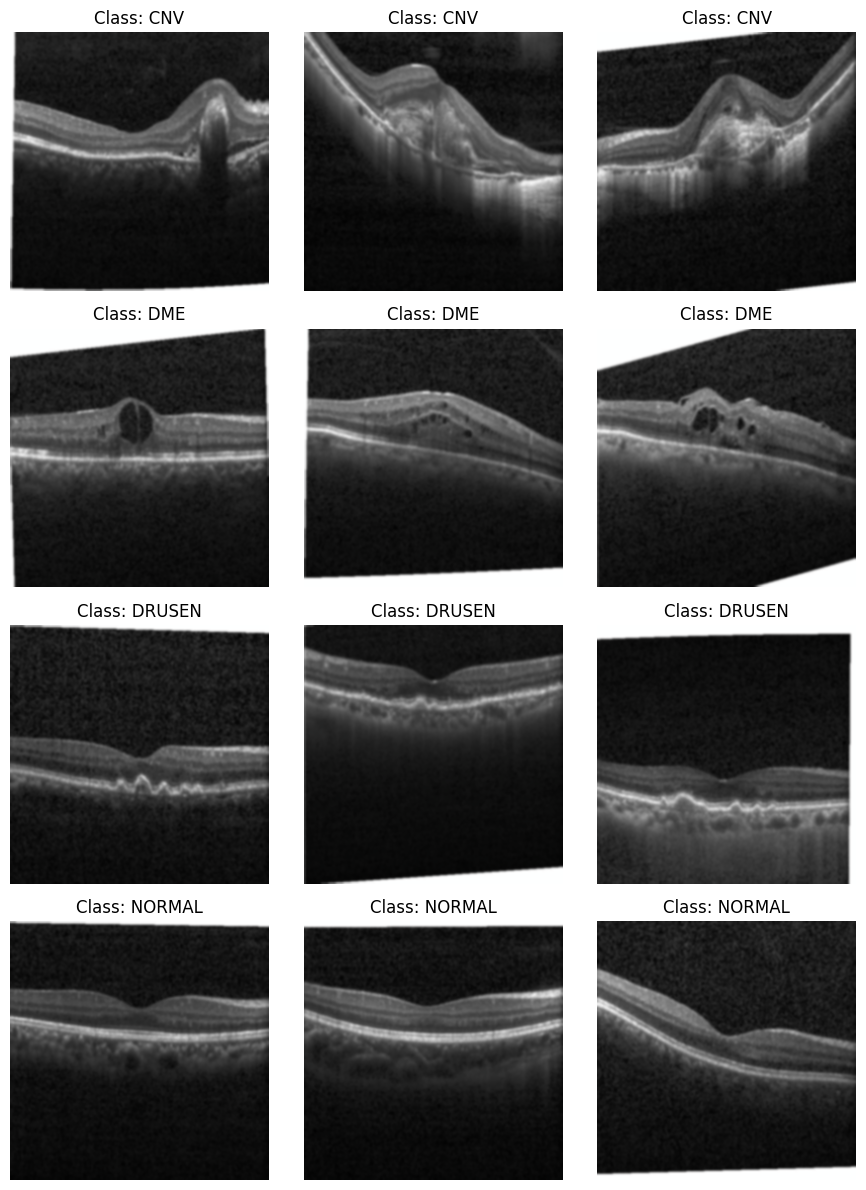

In [6]:
visualize_samples(test_dataset, classes) ### Gaussian Blur

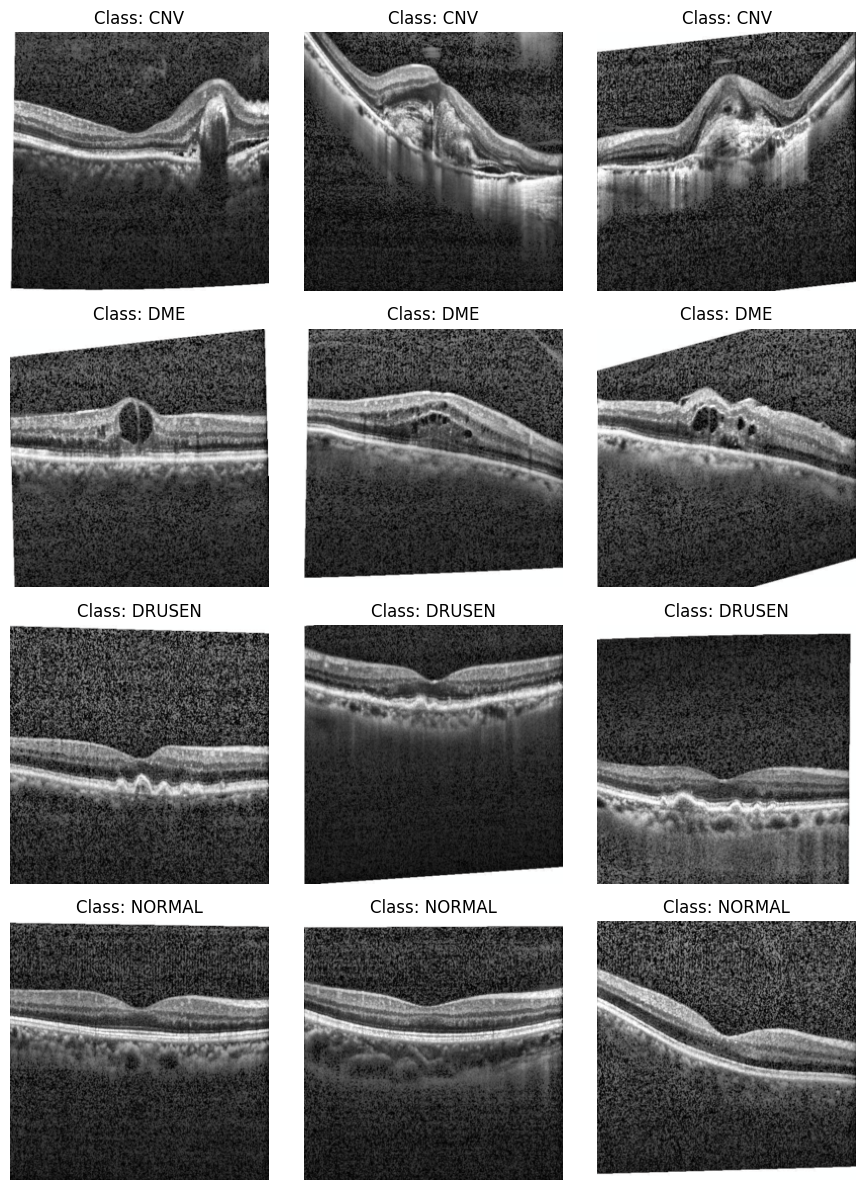

In [6]:
visualize_samples(test_dataset, classes) ### CLAHE

In [9]:
# Count the number of occurrences of each label
class_counts = Counter(train_dataset.targets)
for class_idx, count in class_counts.items():
    print(f"Class '{classes[class_idx]}' has {count} samples.")

Class 'CNV' has 23221 samples.
Class 'DME' has 6386 samples.
Class 'DRUSEN' has 4887 samples.
Class 'NORMAL' has 30694 samples.


In [ ]:
## Balancing Dataset - Optional

min_samples_per_class = min(class_counts.values()) ## Use this to limit count to class with min number of images 
min_samples_per_class = 750 ## Use this to specify number of samples

class_indices = defaultdict(list)

# Populate the class indices dictionary
for idx, label in enumerate(train_dataset.targets):
    class_indices[label].append(idx)

balanced_indices = []
for label, indices in class_indices.items():
    # Randomly sample 'min_samples_per_class' indices from each class
    sampled_indices = random.sample(indices, min_samples_per_class)
    balanced_indices.extend(sampled_indices)

# Create a balanced subset of the original dataset
balanced_train_dataset = Subset(train_dataset, balanced_indices)
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True, drop_last=True)

print(f"Total samples in the balanced dataset: {len(balanced_train_dataset)}")

subset_labels = [train_dataset.targets[idx] for idx in balanced_train_dataset.indices]
subset_class_counts = Counter(subset_labels)
for class_idx, count in subset_class_counts.items():
    print(f"Class '{classes[class_idx]}' has {count} samples in the balanced subset.")

Total samples in the balanced dataset: 3000
Class 'CNV' has 750 samples in the balanced subset.
Class 'DME' has 750 samples in the balanced subset.
Class 'DRUSEN' has 750 samples in the balanced subset.
Class 'NORMAL' has 750 samples in the balanced subset.


In [23]:
# 1. Compute class weights based on the frequency of each class in the training dataset
class_labels = [label for _, label in train_dataset.imgs]  # Extract all labels from the training set
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)

# Convert class weights to a tensor (for use with CrossEntropyLoss)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [24]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) ## Use this loss for weighted loss if imbalanced data
num_epochs = 20

### Initial approach - Resnet50 on entire dataset

RAW Images

In [ ]:
resnet50, optimizer = resnet50_modelinit()

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Epoch [1/20], Train Loss: 71.7881, Train Acc: 0.4936, Val Loss: 43.5431, Val Accuracy: 0.83, Epoch Time: 131.53s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


Epoch [2/20], Train Loss: 54.9124, Train Acc: 0.6586, Val Loss: 37.6580, Val Accuracy: 0.84, Epoch Time: 67.45s
Saving weights...


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch [3/20], Train Loss: 51.1611, Train Acc: 0.6777, Val Loss: 30.2633, Val Accuracy: 0.85, Epoch Time: 117.49s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


Epoch [4/20], Train Loss: 48.2653, Train Acc: 0.7017, Val Loss: 30.8548, Val Accuracy: 0.83, Epoch Time: 69.94s


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


Epoch [5/20], Train Loss: 48.1087, Train Acc: 0.7020, Val Loss: 28.4825, Val Accuracy: 0.85, Epoch Time: 68.60s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch [6/20], Train Loss: 48.5403, Train Acc: 0.6994, Val Loss: 38.3212, Val Accuracy: 0.79, Epoch Time: 69.70s


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Epoch [7/20], Train Loss: 46.0796, Train Acc: 0.7169, Val Loss: 26.9872, Val Accuracy: 0.85, Epoch Time: 70.30s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Epoch [8/20], Train Loss: 45.8442, Train Acc: 0.7206, Val Loss: 25.3470, Val Accuracy: 0.87, Epoch Time: 70.41s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Epoch [9/20], Train Loss: 45.8846, Train Acc: 0.7208, Val Loss: 27.2933, Val Accuracy: 0.86, Epoch Time: 71.25s


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


Epoch [10/20], Train Loss: 45.4235, Train Acc: 0.7249, Val Loss: 31.8502, Val Accuracy: 0.84, Epoch Time: 70.69s


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


Epoch [11/20], Train Loss: 45.5018, Train Acc: 0.7181, Val Loss: 27.0107, Val Accuracy: 0.87, Epoch Time: 72.20s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch [12/20], Train Loss: 45.9309, Train Acc: 0.7192, Val Loss: 36.1597, Val Accuracy: 0.78, Epoch Time: 70.64s


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


Epoch [13/20], Train Loss: 45.4933, Train Acc: 0.7249, Val Loss: 29.7307, Val Accuracy: 0.85, Epoch Time: 70.12s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


Epoch [14/20], Train Loss: 46.9267, Train Acc: 0.7153, Val Loss: 31.4964, Val Accuracy: 0.82, Epoch Time: 70.70s


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Epoch [15/20], Train Loss: 44.9736, Train Acc: 0.7231, Val Loss: 28.4354, Val Accuracy: 0.87, Epoch Time: 70.29s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


Epoch [16/20], Train Loss: 44.5931, Train Acc: 0.7316, Val Loss: 29.0907, Val Accuracy: 0.84, Epoch Time: 70.58s


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


Epoch [17/20], Train Loss: 44.8736, Train Acc: 0.7280, Val Loss: 25.8990, Val Accuracy: 0.87, Epoch Time: 70.81s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Epoch [18/20], Train Loss: 43.6848, Train Acc: 0.7340, Val Loss: 29.7326, Val Accuracy: 0.87, Epoch Time: 70.36s


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


Epoch [19/20], Train Loss: 44.1690, Train Acc: 0.7312, Val Loss: 28.4740, Val Accuracy: 0.85, Epoch Time: 70.61s
Saving weights...


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Epoch [20/20], Train Loss: 42.3133, Train Acc: 0.7430, Val Loss: 27.6746, Val Accuracy: 0.87, Epoch Time: 71.25s
Saving weights...


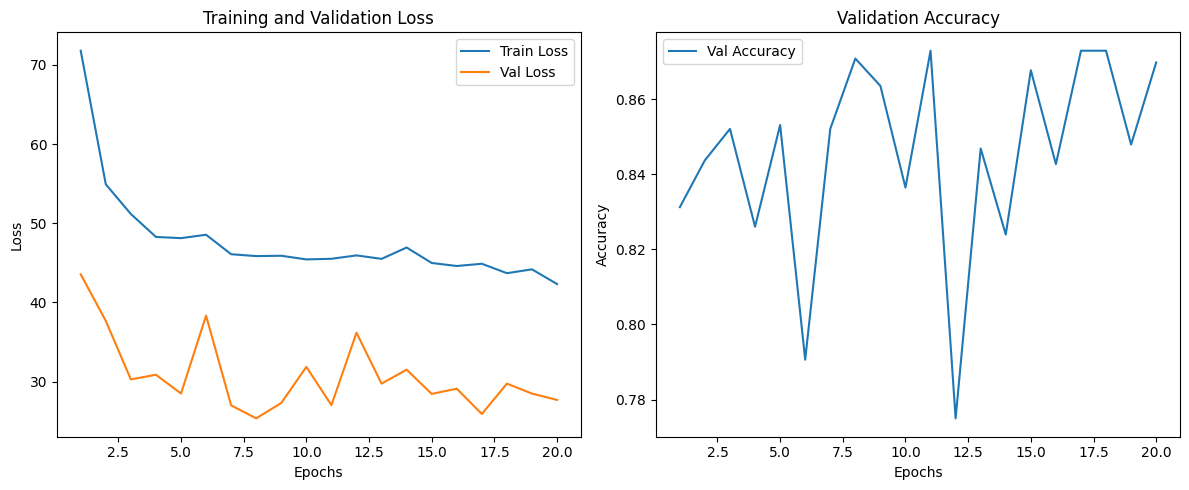

Total Training Time: 1517.06s


In [ ]:
model_name="resnet50"
resnet50, _, _ = train_fn(resnet50, balanced_train_loader, test_loader, model_name, num_epochs, device=device, optimizer=optimizer)

In [22]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

Validation Accuracy: 0.8323
Validation F1: 0.8314


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch [1/20], Train Loss: 71.0253, Train Acc: 0.5104, Val Loss: 50.6244, Val Accuracy: 0.72, Epoch Time: 131.01s
Saving weights...


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


Epoch [2/20], Train Loss: 54.7280, Train Acc: 0.6506, Val Loss: 62.0000, Val Accuracy: 0.55, Epoch Time: 71.11s


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


Epoch [3/20], Train Loss: 51.3284, Train Acc: 0.6867, Val Loss: 45.4491, Val Accuracy: 0.75, Epoch Time: 70.66s
Saving weights...


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Epoch [4/20], Train Loss: 49.9401, Train Acc: 0.6936, Val Loss: 36.7803, Val Accuracy: 0.81, Epoch Time: 123.59s
Saving weights...


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch [5/20], Train Loss: 49.3241, Train Acc: 0.7056, Val Loss: 42.4423, Val Accuracy: 0.75, Epoch Time: 83.04s


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Epoch [6/20], Train Loss: 48.8828, Train Acc: 0.7009, Val Loss: 37.4070, Val Accuracy: 0.79, Epoch Time: 72.52s


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch [7/20], Train Loss: 47.8105, Train Acc: 0.7116, Val Loss: 34.9104, Val Accuracy: 0.81, Epoch Time: 72.57s


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


Epoch [8/20], Train Loss: 48.0931, Train Acc: 0.7074, Val Loss: 34.7955, Val Accuracy: 0.83, Epoch Time: 74.72s
Saving weights...


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Epoch [9/20], Train Loss: 48.1828, Train Acc: 0.7107, Val Loss: 35.4835, Val Accuracy: 0.81, Epoch Time: 80.03s


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Epoch [10/20], Train Loss: 47.4565, Train Acc: 0.7076, Val Loss: 37.6760, Val Accuracy: 0.83, Epoch Time: 87.67s


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch [11/20], Train Loss: 45.8714, Train Acc: 0.7214, Val Loss: 33.2663, Val Accuracy: 0.80, Epoch Time: 83.46s


100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


Epoch [12/20], Train Loss: 47.1103, Train Acc: 0.7179, Val Loss: 40.3811, Val Accuracy: 0.75, Epoch Time: 97.37s


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Epoch [13/20], Train Loss: 46.6489, Train Acc: 0.7177, Val Loss: 33.7147, Val Accuracy: 0.81, Epoch Time: 179.82s


100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Epoch [14/20], Train Loss: 45.4696, Train Acc: 0.7258, Val Loss: 36.8630, Val Accuracy: 0.82, Epoch Time: 177.05s


100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


Epoch [15/20], Train Loss: 45.5963, Train Acc: 0.7244, Val Loss: 36.7297, Val Accuracy: 0.78, Epoch Time: 174.59s


100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


Epoch [16/20], Train Loss: 45.2871, Train Acc: 0.7324, Val Loss: 32.9356, Val Accuracy: 0.83, Epoch Time: 172.76s


100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


Epoch [17/20], Train Loss: 45.2980, Train Acc: 0.7224, Val Loss: 33.9180, Val Accuracy: 0.83, Epoch Time: 171.76s


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Epoch [18/20], Train Loss: 45.1527, Train Acc: 0.7251, Val Loss: 36.0014, Val Accuracy: 0.79, Epoch Time: 173.35s


100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


Epoch [19/20], Train Loss: 44.5087, Train Acc: 0.7289, Val Loss: 36.3963, Val Accuracy: 0.80, Epoch Time: 172.89s


100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Epoch [20/20], Train Loss: 44.0575, Train Acc: 0.7269, Val Loss: 37.1283, Val Accuracy: 0.79, Epoch Time: 171.93s


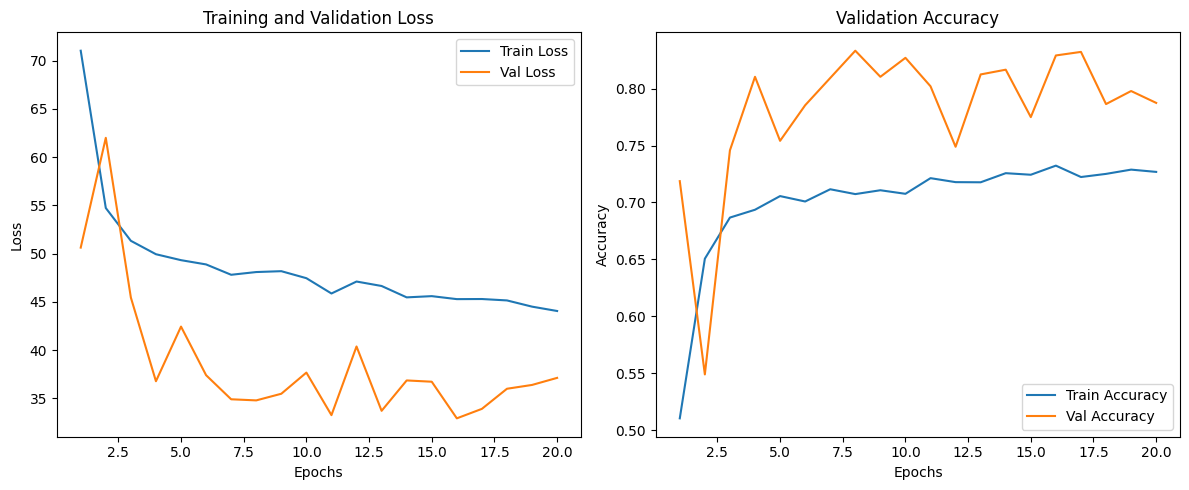

Total Training Time: 2442.64s


In [10]:
model_name="resnet50_clahe"
resnet50, _, _ = train_fn(resnet50, balanced_train_loader, test_loader, model_name, num_epochs, device=device, optimizer=optimizer)

In [12]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

Validation Accuracy: 0.8333
Validation F1: 0.8349


100%|██████████| 15/15 [00:26<00:00,  1.74s/it]


Epoch [1/20], Train Loss: 73.8313, Train Acc: 0.4811, Val Loss: 49.3066, Val Accuracy: 0.71, Epoch Time: 242.51s
Saving weights...


100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


Epoch [2/20], Train Loss: 55.7255, Train Acc: 0.6455, Val Loss: 42.4784, Val Accuracy: 0.78, Epoch Time: 143.57s
Saving weights...


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


Epoch [3/20], Train Loss: 54.4976, Train Acc: 0.6636, Val Loss: 46.7797, Val Accuracy: 0.73, Epoch Time: 134.35s


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch [4/20], Train Loss: 51.8701, Train Acc: 0.6805, Val Loss: 47.3002, Val Accuracy: 0.73, Epoch Time: 137.39s


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch [5/20], Train Loss: 51.2177, Train Acc: 0.6817, Val Loss: 53.5041, Val Accuracy: 0.62, Epoch Time: 136.57s


100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch [6/20], Train Loss: 52.6444, Train Acc: 0.6671, Val Loss: 41.5733, Val Accuracy: 0.77, Epoch Time: 137.39s


100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch [7/20], Train Loss: 52.4009, Train Acc: 0.6776, Val Loss: 43.2743, Val Accuracy: 0.75, Epoch Time: 136.31s


100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch [8/20], Train Loss: 51.7833, Train Acc: 0.6823, Val Loss: 39.4057, Val Accuracy: 0.81, Epoch Time: 136.99s
Saving weights...


100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch [9/20], Train Loss: 50.6197, Train Acc: 0.6949, Val Loss: 37.1884, Val Accuracy: 0.81, Epoch Time: 137.18s
Saving weights...


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch [10/20], Train Loss: 50.9598, Train Acc: 0.6893, Val Loss: 39.1641, Val Accuracy: 0.78, Epoch Time: 136.66s


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch [11/20], Train Loss: 48.6416, Train Acc: 0.6971, Val Loss: 35.0233, Val Accuracy: 0.82, Epoch Time: 137.84s
Saving weights...


100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch [12/20], Train Loss: 49.1621, Train Acc: 0.6983, Val Loss: 35.9807, Val Accuracy: 0.80, Epoch Time: 137.85s


100%|██████████| 15/15 [00:18<00:00,  1.26s/it]


Epoch [13/20], Train Loss: 48.0399, Train Acc: 0.7134, Val Loss: 38.5638, Val Accuracy: 0.81, Epoch Time: 137.32s


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch [14/20], Train Loss: 48.2181, Train Acc: 0.7067, Val Loss: 35.9312, Val Accuracy: 0.81, Epoch Time: 137.62s


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch [15/20], Train Loss: 47.2827, Train Acc: 0.7095, Val Loss: 35.6264, Val Accuracy: 0.81, Epoch Time: 135.98s


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch [16/20], Train Loss: 47.6311, Train Acc: 0.7074, Val Loss: 35.6316, Val Accuracy: 0.81, Epoch Time: 137.92s


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch [17/20], Train Loss: 47.7822, Train Acc: 0.7005, Val Loss: 39.0290, Val Accuracy: 0.79, Epoch Time: 137.47s


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch [18/20], Train Loss: 47.6884, Train Acc: 0.7067, Val Loss: 39.5745, Val Accuracy: 0.78, Epoch Time: 138.24s


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch [19/20], Train Loss: 46.7708, Train Acc: 0.7114, Val Loss: 36.8274, Val Accuracy: 0.80, Epoch Time: 138.77s


100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


Epoch [20/20], Train Loss: 46.2854, Train Acc: 0.7180, Val Loss: 39.3096, Val Accuracy: 0.81, Epoch Time: 138.42s


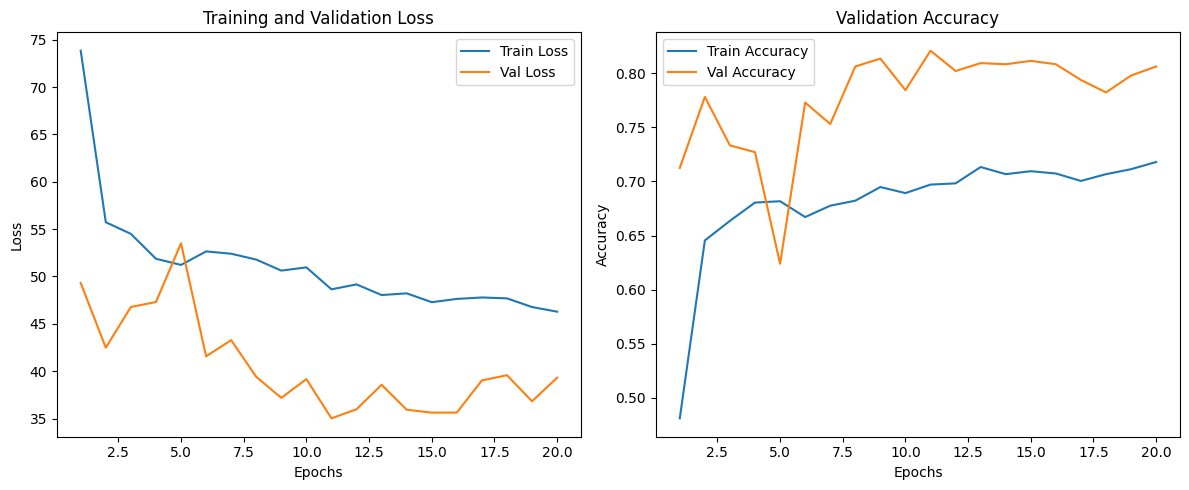

Total Training Time: 2857.37s


In [12]:
model_name="resnet50_bilateral"
resnet50, _, _ = train_fn(resnet50, balanced_train_loader, test_loader, model_name, num_epochs, device=device, optimizer=optimizer)

In [13]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

Validation Accuracy: 0.8208
Validation F1: 0.8200


### Smaller dataset: 750 per class train, 250 per class test

100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


Epoch [1/20], Train Loss: 86.7189, Train Acc: 0.3505, Val Loss: 69.1786, Val Accuracy: 0.56, Epoch Time: 89.75s
Saving weights...


100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch [2/20], Train Loss: 68.3447, Train Acc: 0.5336, Val Loss: 57.0019, Val Accuracy: 0.66, Epoch Time: 61.88s
Saving weights...


100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


Epoch [3/20], Train Loss: 59.3843, Train Acc: 0.6182, Val Loss: 45.8852, Val Accuracy: 0.77, Epoch Time: 65.70s
Saving weights...


100%|██████████| 15/15 [00:18<00:00,  1.26s/it]


Epoch [4/20], Train Loss: 56.0691, Train Acc: 0.6416, Val Loss: 48.4643, Val Accuracy: 0.73, Epoch Time: 65.18s


100%|██████████| 15/15 [00:17<00:00,  1.20s/it]


Epoch [5/20], Train Loss: 52.9612, Train Acc: 0.6709, Val Loss: 43.0671, Val Accuracy: 0.76, Epoch Time: 61.05s


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch [6/20], Train Loss: 51.3297, Train Acc: 0.6780, Val Loss: 47.5938, Val Accuracy: 0.71, Epoch Time: 61.31s


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


Epoch [7/20], Train Loss: 51.9302, Train Acc: 0.6797, Val Loss: 39.4237, Val Accuracy: 0.77, Epoch Time: 60.89s
Saving weights...


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


Epoch [8/20], Train Loss: 51.4808, Train Acc: 0.6831, Val Loss: 39.8989, Val Accuracy: 0.78, Epoch Time: 60.13s
Saving weights...


100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch [9/20], Train Loss: 49.2467, Train Acc: 0.6940, Val Loss: 40.7773, Val Accuracy: 0.78, Epoch Time: 61.33s


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


Epoch [10/20], Train Loss: 50.7340, Train Acc: 0.6705, Val Loss: 41.7528, Val Accuracy: 0.75, Epoch Time: 61.17s


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


Epoch [11/20], Train Loss: 49.6987, Train Acc: 0.6953, Val Loss: 44.7130, Val Accuracy: 0.73, Epoch Time: 59.40s


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch [12/20], Train Loss: 47.5027, Train Acc: 0.7103, Val Loss: 42.9093, Val Accuracy: 0.78, Epoch Time: 60.36s


100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch [13/20], Train Loss: 47.0573, Train Acc: 0.7181, Val Loss: 51.2114, Val Accuracy: 0.65, Epoch Time: 62.11s


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


Epoch [14/20], Train Loss: 47.6738, Train Acc: 0.7116, Val Loss: 38.4699, Val Accuracy: 0.79, Epoch Time: 60.61s
Saving weights...


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch [15/20], Train Loss: 46.4870, Train Acc: 0.7082, Val Loss: 40.1686, Val Accuracy: 0.77, Epoch Time: 61.33s


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch [16/20], Train Loss: 45.0199, Train Acc: 0.7133, Val Loss: 37.6398, Val Accuracy: 0.78, Epoch Time: 62.14s


100%|██████████| 15/15 [00:18<00:00,  1.26s/it]


Epoch [17/20], Train Loss: 45.0974, Train Acc: 0.7296, Val Loss: 46.7650, Val Accuracy: 0.72, Epoch Time: 62.77s


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Epoch [18/20], Train Loss: 46.5347, Train Acc: 0.7194, Val Loss: 42.0044, Val Accuracy: 0.74, Epoch Time: 58.11s


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Epoch [19/20], Train Loss: 46.5665, Train Acc: 0.7143, Val Loss: 41.1593, Val Accuracy: 0.77, Epoch Time: 55.75s


100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Epoch [20/20], Train Loss: 46.2296, Train Acc: 0.7137, Val Loss: 40.3753, Val Accuracy: 0.76, Epoch Time: 56.09s


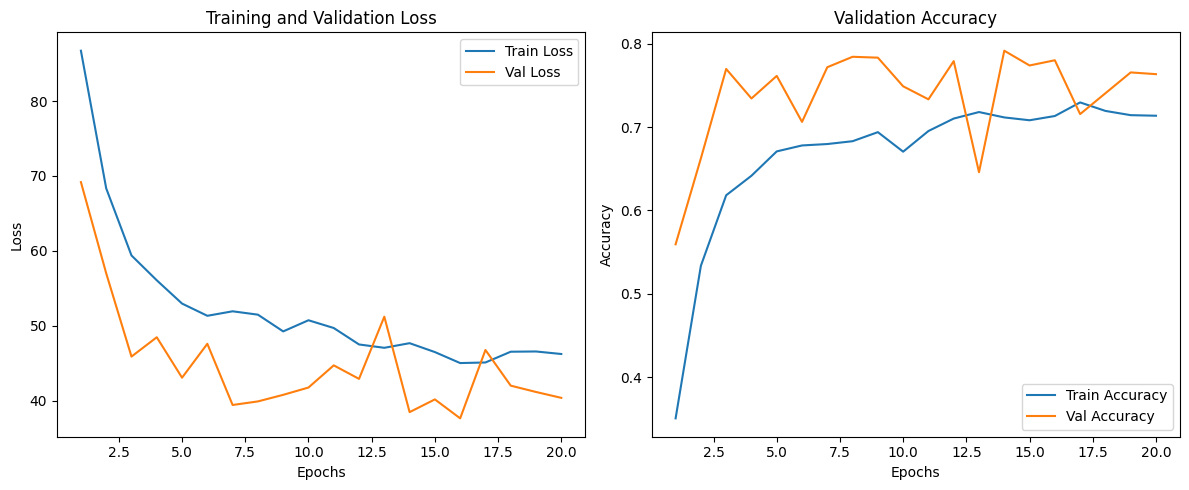

Total Training Time: 1248.99s


In [11]:
model_name="resnet50_bilateral"
resnet50, _, _ = train_fn(resnet50, balanced_train_loader, test_loader, model_name, num_epochs, device=device, optimizer=optimizer)

In [ ]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Epoch [1/20], Train Loss: 60.4255, Train Acc: 0.6226, Val Loss: 47.4514, Val Accuracy: 0.73, Epoch Time: 49.89s
Saving weights...


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


Epoch [2/20], Train Loss: 57.5786, Train Acc: 0.6444, Val Loss: 43.1853, Val Accuracy: 0.77, Epoch Time: 31.40s
Saving weights...


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch [3/20], Train Loss: 52.2886, Train Acc: 0.6753, Val Loss: 41.5534, Val Accuracy: 0.79, Epoch Time: 31.80s
Saving weights...


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Epoch [4/20], Train Loss: 51.7931, Train Acc: 0.6790, Val Loss: 41.6567, Val Accuracy: 0.78, Epoch Time: 32.27s


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


Epoch [5/20], Train Loss: 50.7726, Train Acc: 0.6940, Val Loss: 43.3428, Val Accuracy: 0.76, Epoch Time: 31.51s


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Epoch [6/20], Train Loss: 48.6003, Train Acc: 0.7116, Val Loss: 39.2888, Val Accuracy: 0.77, Epoch Time: 31.90s


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


Epoch [7/20], Train Loss: 51.0626, Train Acc: 0.6827, Val Loss: 37.7424, Val Accuracy: 0.80, Epoch Time: 32.17s
Saving weights...


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


Epoch [8/20], Train Loss: 49.1339, Train Acc: 0.6977, Val Loss: 38.1411, Val Accuracy: 0.78, Epoch Time: 33.00s


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Epoch [9/20], Train Loss: 47.5560, Train Acc: 0.7055, Val Loss: 34.6722, Val Accuracy: 0.81, Epoch Time: 33.38s
Saving weights...


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Epoch [10/20], Train Loss: 47.0470, Train Acc: 0.7096, Val Loss: 36.5378, Val Accuracy: 0.81, Epoch Time: 35.59s


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


Epoch [11/20], Train Loss: 46.1431, Train Acc: 0.7211, Val Loss: 34.2483, Val Accuracy: 0.81, Epoch Time: 33.76s
Saving weights...


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch [12/20], Train Loss: 45.7129, Train Acc: 0.7177, Val Loss: 40.1014, Val Accuracy: 0.77, Epoch Time: 32.38s


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


Epoch [13/20], Train Loss: 48.0989, Train Acc: 0.7120, Val Loss: 34.5439, Val Accuracy: 0.82, Epoch Time: 33.03s
Saving weights...


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Epoch [14/20], Train Loss: 47.1942, Train Acc: 0.7048, Val Loss: 36.5786, Val Accuracy: 0.81, Epoch Time: 35.78s


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


Epoch [15/20], Train Loss: 44.9245, Train Acc: 0.7201, Val Loss: 37.4967, Val Accuracy: 0.78, Epoch Time: 32.75s


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch [16/20], Train Loss: 44.5031, Train Acc: 0.7252, Val Loss: 39.9269, Val Accuracy: 0.78, Epoch Time: 35.44s


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch [17/20], Train Loss: 43.8669, Train Acc: 0.7211, Val Loss: 37.7883, Val Accuracy: 0.77, Epoch Time: 37.42s


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Epoch [18/20], Train Loss: 43.6501, Train Acc: 0.7225, Val Loss: 33.5372, Val Accuracy: 0.80, Epoch Time: 40.07s


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


Epoch [19/20], Train Loss: 44.9406, Train Acc: 0.7120, Val Loss: 37.6167, Val Accuracy: 0.78, Epoch Time: 58.46s


100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


Epoch [20/20], Train Loss: 45.3691, Train Acc: 0.7201, Val Loss: 38.9973, Val Accuracy: 0.76, Epoch Time: 81.66s


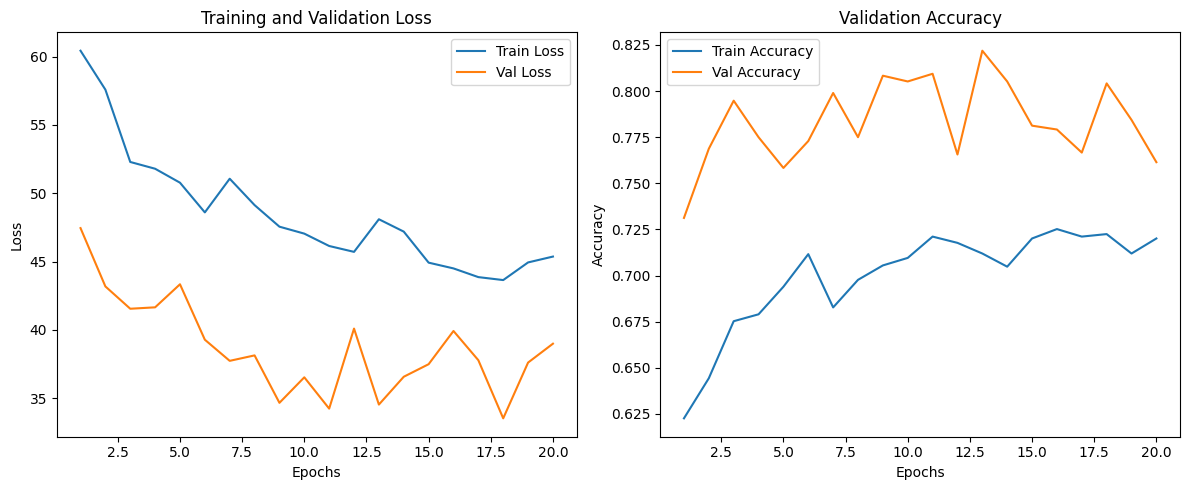

Total Training Time: 764.74s


In [21]:
model_name="resnet50_clahe"
resnet50, _, _ = train_fn(resnet50, balanced_train_loader, test_loader, model_name, num_epochs, device=device, optimizer=optimizer)

In [22]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

Validation Accuracy: 0.8219
Validation F1: 0.8199


100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


Epoch [1/20], Train Loss: 85.4199, Train Acc: 0.3434, Val Loss: 81.1751, Val Accuracy: 0.39, Epoch Time: 115.37s
Saving weights...


100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Epoch [2/20], Train Loss: 70.9197, Train Acc: 0.5241, Val Loss: 66.5576, Val Accuracy: 0.57, Epoch Time: 75.10s
Saving weights...


100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


Epoch [3/20], Train Loss: 63.7865, Train Acc: 0.5859, Val Loss: 79.4893, Val Accuracy: 0.39, Epoch Time: 70.05s


100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


Epoch [4/20], Train Loss: 62.5257, Train Acc: 0.5992, Val Loss: 61.5883, Val Accuracy: 0.60, Epoch Time: 68.61s
Saving weights...


100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


Epoch [5/20], Train Loss: 62.8543, Train Acc: 0.5853, Val Loss: 61.6798, Val Accuracy: 0.59, Epoch Time: 69.06s


100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


Epoch [6/20], Train Loss: 59.6484, Train Acc: 0.6002, Val Loss: 64.2103, Val Accuracy: 0.56, Epoch Time: 78.06s


100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


Epoch [7/20], Train Loss: 56.4030, Train Acc: 0.6311, Val Loss: 59.0228, Val Accuracy: 0.62, Epoch Time: 79.44s
Saving weights...


100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


Epoch [8/20], Train Loss: 55.1375, Train Acc: 0.6447, Val Loss: 62.0566, Val Accuracy: 0.57, Epoch Time: 81.94s


100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


Epoch [9/20], Train Loss: 56.6449, Train Acc: 0.6386, Val Loss: 58.4674, Val Accuracy: 0.62, Epoch Time: 86.40s
Saving weights...


100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


Epoch [10/20], Train Loss: 56.0738, Train Acc: 0.6382, Val Loss: 61.0173, Val Accuracy: 0.58, Epoch Time: 92.41s


100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


Epoch [11/20], Train Loss: 52.9062, Train Acc: 0.6630, Val Loss: 60.7394, Val Accuracy: 0.59, Epoch Time: 84.13s


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Epoch [12/20], Train Loss: 54.8257, Train Acc: 0.6539, Val Loss: 61.1033, Val Accuracy: 0.56, Epoch Time: 96.49s


100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


Epoch [13/20], Train Loss: 54.8274, Train Acc: 0.6525, Val Loss: 62.6047, Val Accuracy: 0.55, Epoch Time: 87.76s


100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


Epoch [14/20], Train Loss: 54.7143, Train Acc: 0.6495, Val Loss: 61.0249, Val Accuracy: 0.62, Epoch Time: 80.37s


100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


Epoch [15/20], Train Loss: 55.6478, Train Acc: 0.6461, Val Loss: 57.2402, Val Accuracy: 0.65, Epoch Time: 79.39s
Saving weights...


100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


Epoch [16/20], Train Loss: 54.4951, Train Acc: 0.6525, Val Loss: 64.2374, Val Accuracy: 0.53, Epoch Time: 95.17s


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


Epoch [17/20], Train Loss: 55.3541, Train Acc: 0.6362, Val Loss: 68.9329, Val Accuracy: 0.48, Epoch Time: 106.37s


100%|██████████| 15/15 [00:30<00:00,  2.05s/it]


Epoch [18/20], Train Loss: 53.7186, Train Acc: 0.6488, Val Loss: 64.1272, Val Accuracy: 0.55, Epoch Time: 116.34s


100%|██████████| 15/15 [00:26<00:00,  1.77s/it]


Epoch [19/20], Train Loss: 53.3553, Train Acc: 0.6569, Val Loss: 65.2457, Val Accuracy: 0.53, Epoch Time: 99.76s


100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


Epoch [20/20], Train Loss: 54.3204, Train Acc: 0.6457, Val Loss: 59.2980, Val Accuracy: 0.59, Epoch Time: 91.15s


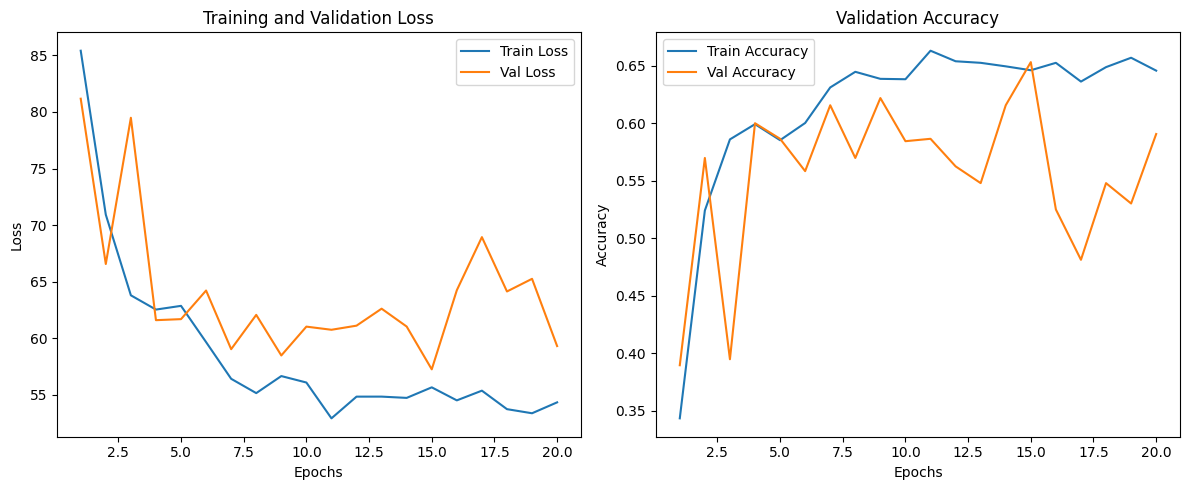

Total Training Time: 1755.96s


In [27]:
model_name="resnet50_edge"
resnet50, _, _ = train_fn(resnet50, balanced_train_loader, test_loader, model_name, num_epochs, device=device, optimizer=optimizer)

In [28]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

Validation Accuracy: 0.6531
Validation F1: 0.6454


### Three model preprocessing approach

In [35]:
preprocess_transforms = [GaussianBlur(), CLAHETransform(), CannyEdgeTransform()]
preprocess_model_names = ["resnet50_bilateral", "resnet50_clahe", "resnet50_edge"]
preprocess_models= []
for model_name in preprocess_model_names:
    resnet50, optimizer = resnet50_modelinit()
    resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
    resnet50.fc = nn.Identity() 
    resnet50 = resnet50.to(device)
    preprocess_models.append(resnet50)

class FeatureExtract:
    def __call__(self, img):
        # Convert PIL image to numpy array for OpenCV
        embedding = []
        img = np.array(img)
        for transform, model in zip(preprocess_transforms, preprocess_models):
            transformed_img = transform(img)
            transformed_img = torch.tensor(transformed_img)
            transformed_img = transformed_img.unsqueeze(0)  # Shape: [1, 3, 224, 224]
            out = model(transformed_img)
            embedding.append(out)
        return np.array(embedding)

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# Use the CLAHETransform in your transforms pipeline
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to tensor
    FeatureExtract(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    FeatureExtract(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [37]:
# Load training and testing datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [38]:
train_dataset[0]

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\bilateral_filter.dispatch.cpp:233: error: (-215:Assertion failed) (src.type() == CV_32FC1 || src.type() == CV_32FC3) && src.data != dst.data in function 'cv::bilateralFilter_32f'


### Resnet v2 - 60-40 split on entire train data based on patient ID with class weights based on number of images

In [18]:
resnet50, optimizer = resnet50_modelinit()
model_name="resnet50_v2"

Bilateral filtered

In [ ]:
resnet50, _, _ = train_fn(resnet50, train_loader, test_loader, model_name, num_epochs, criterion=criterion, device=device, optimizer=optimizer)

100%|██████████| 673/673 [18:35<00:00,  1.66s/it]


Epoch [1/20], Train Loss: 61.6003, Train Acc: 0.6689, Val Loss: 44.2578, Val Accuracy: 0.79, Epoch Time: 2693.93s
Saving weights...


100%|██████████| 673/673 [18:45<00:00,  1.67s/it]


Epoch [2/20], Train Loss: 54.4629, Train Acc: 0.7144, Val Loss: 45.9544, Val Accuracy: 0.75, Epoch Time: 2649.81s


100%|██████████| 673/673 [18:56<00:00,  1.69s/it]


Epoch [3/20], Train Loss: 52.3475, Train Acc: 0.7256, Val Loss: 46.1263, Val Accuracy: 0.79, Epoch Time: 2633.85s
Saving weights...


100%|██████████| 673/673 [19:34<00:00,  1.74s/it]


Epoch [4/20], Train Loss: 50.5045, Train Acc: 0.7356, Val Loss: 44.0320, Val Accuracy: 0.80, Epoch Time: 2693.55s
Saving weights...


100%|██████████| 673/673 [19:05<00:00,  1.70s/it]


Epoch [5/20], Train Loss: 49.3460, Train Acc: 0.7412, Val Loss: 48.4916, Val Accuracy: 0.72, Epoch Time: 2701.53s


100%|██████████| 673/673 [19:46<00:00,  1.76s/it]


Epoch [6/20], Train Loss: 48.7876, Train Acc: 0.7464, Val Loss: 49.2648, Val Accuracy: 0.75, Epoch Time: 2714.09s


100%|██████████| 673/673 [20:03<00:00,  1.79s/it]


Epoch [7/20], Train Loss: 48.6380, Train Acc: 0.7461, Val Loss: 49.4103, Val Accuracy: 0.75, Epoch Time: 2899.79s


100%|██████████| 673/673 [20:12<00:00,  1.80s/it]


Epoch [8/20], Train Loss: 47.5947, Train Acc: 0.7539, Val Loss: 51.8003, Val Accuracy: 0.72, Epoch Time: 2786.73s


100%|██████████| 673/673 [22:07<00:00,  1.97s/it]


Epoch [9/20], Train Loss: 47.2483, Train Acc: 0.7532, Val Loss: 47.0508, Val Accuracy: 0.76, Epoch Time: 2972.71s


100%|██████████| 673/673 [18:45<00:00,  1.67s/it]


Epoch [10/20], Train Loss: 47.2367, Train Acc: 0.7533, Val Loss: 46.2760, Val Accuracy: 0.78, Epoch Time: 2650.15s


100%|██████████| 673/673 [18:48<00:00,  1.68s/it]


Epoch [11/20], Train Loss: 46.9060, Train Acc: 0.7552, Val Loss: 47.8451, Val Accuracy: 0.76, Epoch Time: 2648.80s


100%|██████████| 673/673 [18:46<00:00,  1.67s/it]


Epoch [12/20], Train Loss: 46.4215, Train Acc: 0.7589, Val Loss: 47.5160, Val Accuracy: 0.78, Epoch Time: 2656.43s


100%|██████████| 673/673 [18:36<00:00,  1.66s/it]


Epoch [13/20], Train Loss: 46.2242, Train Acc: 0.7530, Val Loss: 50.3375, Val Accuracy: 0.70, Epoch Time: 2638.11s


100%|██████████| 673/673 [18:44<00:00,  1.67s/it]


Epoch [14/20], Train Loss: 45.8261, Train Acc: 0.7583, Val Loss: 52.0589, Val Accuracy: 0.68, Epoch Time: 2654.17s


100%|██████████| 673/673 [18:39<00:00,  1.66s/it]


Epoch [15/20], Train Loss: 45.1219, Train Acc: 0.7624, Val Loss: 47.6278, Val Accuracy: 0.73, Epoch Time: 2644.01s


100%|██████████| 673/673 [22:21<00:00,  1.99s/it]


Epoch [16/20], Train Loss: 44.9409, Train Acc: 0.7637, Val Loss: 52.1693, Val Accuracy: 0.65, Epoch Time: 2867.96s


100%|██████████| 673/673 [28:48<00:00,  2.57s/it]


Epoch [17/20], Train Loss: 45.0785, Train Acc: 0.7619, Val Loss: 49.4344, Val Accuracy: 0.73, Epoch Time: 3530.67s


100%|██████████| 673/673 [19:53<00:00,  1.77s/it]


Epoch [18/20], Train Loss: 44.6367, Train Acc: 0.7655, Val Loss: 49.4888, Val Accuracy: 0.73, Epoch Time: 3312.27s


 66%|██████▌   | 445/673 [13:39<06:05,  1.60s/it]

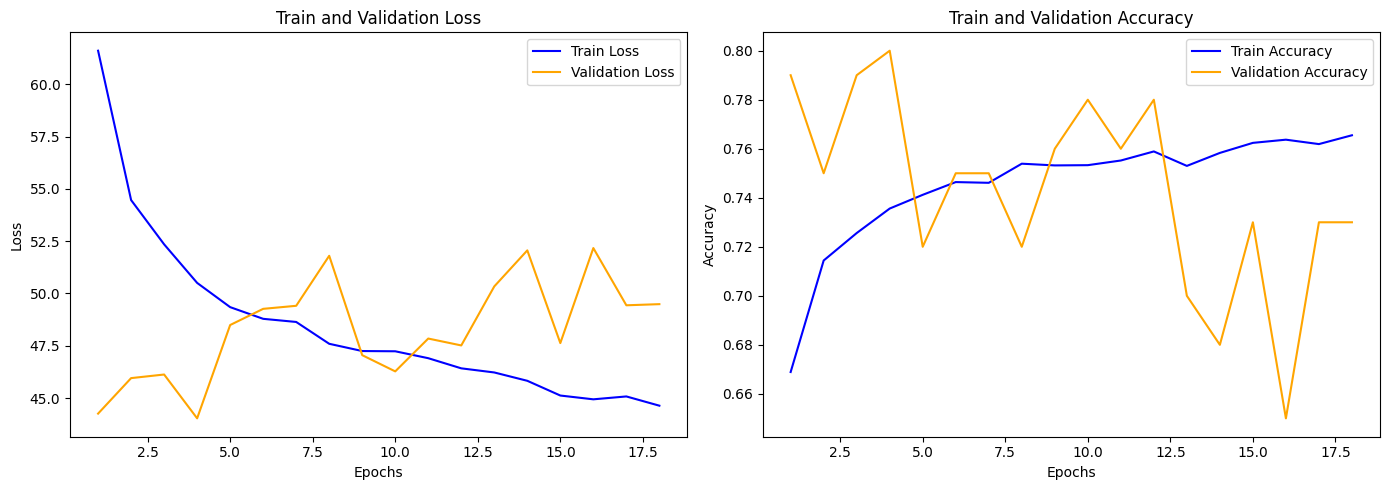

In [22]:
import matplotlib.pyplot as plt

# Data from the epochs
epochs = list(range(1, 19))
train_losses = [
    61.6003, 54.4629, 52.3475, 50.5045, 49.3460, 48.7876, 
    48.6380, 47.5947, 47.2483, 47.2367, 46.9060, 46.4215, 
    46.2242, 45.8261, 45.1219, 44.9409, 45.0785, 44.6367
]
val_losses = [
    44.2578, 45.9544, 46.1263, 44.0320, 48.4916, 49.2648, 
    49.4103, 51.8003, 47.0508, 46.2760, 47.8451, 47.5160, 
    50.3375, 52.0589, 47.6278, 52.1693, 49.4344, 49.4888
]
train_acc = [
    0.6689, 0.7144, 0.7256, 0.7356, 0.7412, 0.7464, 
    0.7461, 0.7539, 0.7532, 0.7533, 0.7552, 0.7589, 
    0.7530, 0.7583, 0.7624, 0.7637, 0.7619, 0.7655
]
val_acc = [
    0.79, 0.75, 0.79, 0.80, 0.72, 0.75, 
    0.75, 0.72, 0.76, 0.78, 0.76, 0.78, 
    0.70, 0.68, 0.73, 0.65, 0.73, 0.73
]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Losses
axs[0].plot(epochs, train_losses, label="Train Loss", color="blue")
axs[0].plot(epochs, val_losses, label="Validation Loss", color="orange")
axs[0].set_title("Train and Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot Accuracies
axs[1].plot(epochs, train_acc, label="Train Accuracy", color="blue")
axs[1].plot(epochs, val_acc, label="Validation Accuracy", color="orange")
axs[1].set_title("Train and Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
torch.save(resnet50.state_dict(), "models/"+model_name+"_final.pth")

In [21]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

100%|██████████| 673/673 [18:47<00:00,  1.68s/it]

Validation Accuracy: 0.7994
Validation F1: 0.7281


In [ ]:
# CNN, LR 10^-5, preprocessing, SWIN

In [6]:
resnet50, optimizer = resnet50_modelinit()
model_name="resnet50_v3" # White cropped
num_epochs=5

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 673/673 [17:55<00:00,  1.60s/it]


Epoch [1/5], Train Loss: 58.0544, Train Acc: 0.6806, Val Loss: 38.0234, Val Accuracy: 0.81, Epoch Time: 2410.98s
Saving weights...


100%|██████████| 673/673 [11:25<00:00,  1.02s/it]


Epoch [2/5], Train Loss: 52.2157, Train Acc: 0.7156, Val Loss: 42.8446, Val Accuracy: 0.75, Epoch Time: 1815.96s


100%|██████████| 673/673 [11:19<00:00,  1.01s/it]


Epoch [3/5], Train Loss: 49.4623, Train Acc: 0.7351, Val Loss: 44.7397, Val Accuracy: 0.76, Epoch Time: 1548.09s


100%|██████████| 673/673 [11:24<00:00,  1.02s/it]


Epoch [4/5], Train Loss: 48.5837, Train Acc: 0.7381, Val Loss: 45.9058, Val Accuracy: 0.76, Epoch Time: 1547.43s


100%|██████████| 673/673 [11:19<00:00,  1.01s/it]


Epoch [5/5], Train Loss: 47.9452, Train Acc: 0.7421, Val Loss: 43.8987, Val Accuracy: 0.79, Epoch Time: 1538.25s


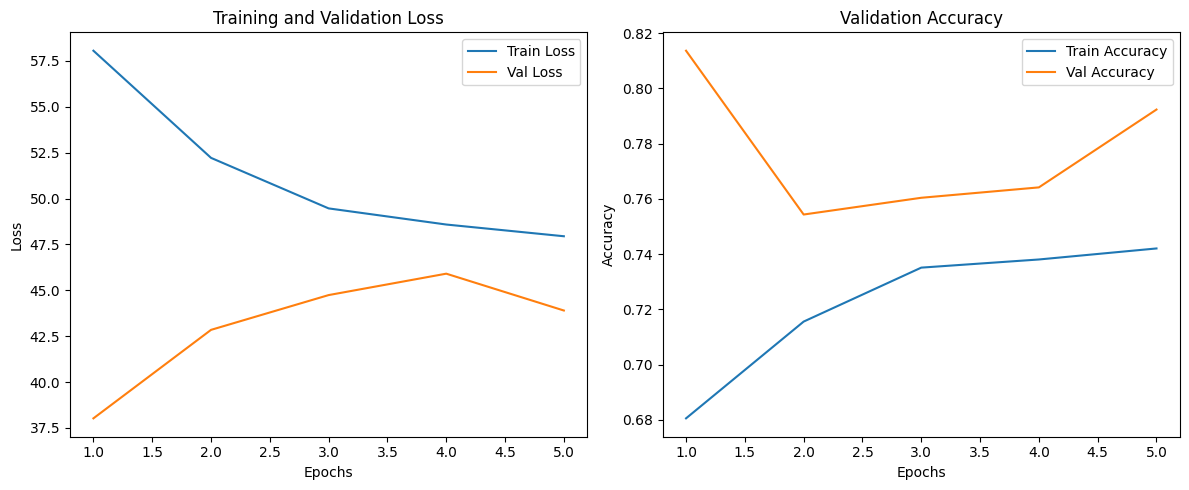

Total Training Time: 8860.89s


In [26]:
resnet50, _, _ = train_fn(resnet50, train_loader, val_loader, model_name, num_epochs, criterion=criterion, device=device, optimizer=optimizer)

In [27]:
torch.save(resnet50.state_dict(), "models/"+model_name+"_final.pth")

In [28]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, val_loader, device=device, binary = False)
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

100%|██████████| 673/673 [11:03<00:00,  1.01it/s]


Validation Accuracy: 0.8136
Validation F1: 0.7172


100%|██████████| 15/15 [00:23<00:00,  1.53s/it]

Validation Accuracy: 0.7594
Validation F1: 0.7515


100%|██████████| 673/673 [17:00<00:00,  1.52s/it]


Epoch [1/5], Train Loss: 52.7552, Train Acc: 0.7083, Val Loss: 48.3261, Val Accuracy: 0.77, Epoch Time: 2394.89s
Saving weights...


100%|██████████| 673/673 [11:31<00:00,  1.03s/it]


Epoch [2/5], Train Loss: 50.2804, Train Acc: 0.7265, Val Loss: 46.8801, Val Accuracy: 0.76, Epoch Time: 1618.96s


100%|██████████| 673/673 [12:55<00:00,  1.15s/it]


Epoch [3/5], Train Loss: 48.6980, Train Acc: 0.7297, Val Loss: 48.2365, Val Accuracy: 0.76, Epoch Time: 1712.88s


100%|██████████| 673/673 [14:49<00:00,  1.32s/it]


Epoch [4/5], Train Loss: 47.7729, Train Acc: 0.7365, Val Loss: 46.6335, Val Accuracy: 0.79, Epoch Time: 1806.09s
Saving weights...


100%|██████████| 673/673 [15:08<00:00,  1.35s/it]


Epoch [5/5], Train Loss: 47.1616, Train Acc: 0.7385, Val Loss: 52.7303, Val Accuracy: 0.70, Epoch Time: 2248.33s


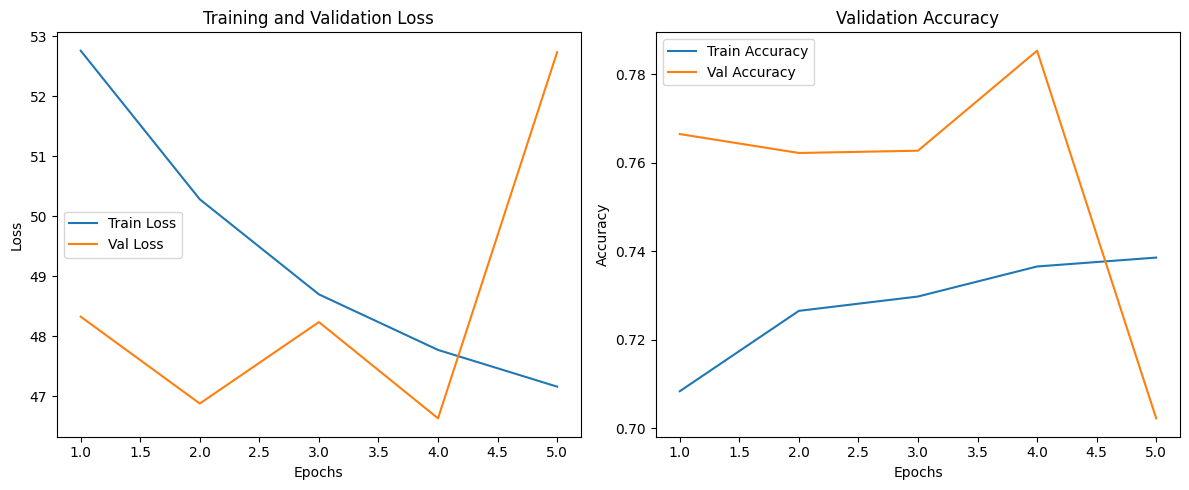

Total Training Time: 9781.46s


In [29]:
resnet50, _, _ = train_fn(resnet50, train_loader, val_loader, model_name, num_epochs, criterion=criterion, device=device, optimizer=optimizer)

In [7]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, val_loader, device=device, binary = False)
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

100%|██████████| 673/673 [11:42<00:00,  1.04s/it]


Validation Accuracy: 0.8006
Validation F1: 0.7260


100%|██████████| 15/15 [00:21<00:00,  1.43s/it]

Validation Accuracy: 0.8125
Validation F1: 0.8109


In [8]:
resnet50, _, _ = train_fn(resnet50, train_loader, val_loader, model_name, num_epochs, criterion=criterion, device=device, optimizer=optimizer)

NameError: name 'criterion' is not defined

### Vision Transformers

Pre-trained weights - trained on 8 class dataset - ViT, SWIN

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import sys, os
from tqdm import tqdm
from transformers import ViTForImageClassification

In [2]:
MODEL_PATH = "models/vit_oct8.pth"  # Change this to your actual .pth file name
IMAGE_PATH = r"data/OCT2017/new_split/train/CNV/CNV-13823-1.jpeg"  # Change this to your test image path
IMAGE_PATH = r"data\RetinalOCT_Dataset\test\AMD\amd_test_1001.jpg"
IMAGE_PATH = r"data/RetinalOCT_Dataset/test/CSR/csr_test_1001.jpg"
TEST_DIR = "data/RetinalOCT_Dataset/test/"  # Root directory containing class subfolders
NUM_CLASSES = 8  # Ensure this matches the number of classes your model was trained on
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

output_label_to_class = {
    0: "AMD",      # Age-related Macular Degeneration
    1: "CNV",      # Choroidal Neovascularization
    2: "CSR",      # Central Serous Retinopathy
    3: "DME",      # Diabetic Macular Edema
    4: "DR",       # Diabetic Retinopathy
    5: "DRUSEN",   # Yellow deposits under the retina
    6: "MH",       # Macular Hole
    7: "NORMAL"    # Normal
}
# Reverse mapping for ground truth comparison
class_to_label = {v: k for k, v in output_label_to_class.items()}

In [ ]:
# Load the model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=NUM_CLASSES, ignore_mismatched_sizes = True)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Define image transformations (match the ones used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def predict(image_path):
    """Runs inference on a single image and returns the predicted class name."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image).logits
        _, predicted_class = torch.max(outputs, 1)

    return output_label_to_class[predicted_class.item()]


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
predicted_label = predict(IMAGE_PATH)
print(f"Predicted class: {predicted_label}")

Predicted class: CSR


In [25]:
# Evaluate model on all test images
correct = 0
total = 0

for class_name in tqdm(os.listdir(TEST_DIR)):
    class_path = os.path.join(TEST_DIR, class_name)
    if not os.path.isdir(class_path):  # Skip non-folder files
        continue

    for image_name in tqdm(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_name)

        if image_path.lower().endswith((".jpg", ".jpeg", ".png")):  # Ensure valid image format
            predicted_label = predict(image_path)
            actual_label = class_to_label[class_name]

            if predicted_label == class_name:
                correct += 1
            total += 1

            # print(f"Image: {image_name}, Actual: {class_name}, Predicted: {[predicted_label]}")

# Calculate accuracy
accuracy = 100 * correct / total if total > 0 else 0
print(f"\nModel Accuracy: {accuracy:.2f}% ({correct}/{total})")

100%|██████████| 8/8 [01:07<00:00,  8.38s/it]


Model Accuracy: 95.82% (2683/2800)


!!! make fns, metrics fn, utils, set up train and eval notebooks, use common utils, models .py files, routines to use different datasets and models, dataset loading functions, use one model and one dataset in memory at all times

In [28]:
TEST_DIR = r"data/OCT2017/new_split/test/"
# Evaluate model on all test images
correct = 0
total = 0

for class_name in (os.listdir(TEST_DIR)):
    class_path = os.path.join(TEST_DIR, class_name)
    if not os.path.isdir(class_path):  # Skip non-folder files
        continue

    for image_name in tqdm(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_name)

        if image_path.lower().endswith((".jpg", ".jpeg", ".png")):  # Ensure valid image format
            predicted_label = predict(image_path)
            actual_label = class_to_label[class_name]

            if predicted_label == class_name:
                correct += 1
            total += 1

            # print(f"Image: {image_name}, Actual: {class_name}, Predicted: {[predicted_label]}")

# Calculate accuracy
accuracy = 100 * correct / total if total > 0 else 0
print(f"\nModel Accuracy: {accuracy:.2f}% ({correct}/{total})")

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:10<00:00, 24.54it/s]


Model Accuracy: 96.60% (966/1000)


### Simpler models test

In [1]:
def plot_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss", marker='o')
    plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), train_accs, label="Train Acc", marker='o')
    plt.plot(range(1, EPOCHS + 1), val_accs, label="Val Acc", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define constants
DATA_DIR = "data/RetinalOCT_Dataset/"
NUM_CLASSES = 8
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 88/88 [00:44<00:00,  1.98it/s]


Epoch 1/10 -> Train Acc: 0.5524 | Val Acc: 0.7261


100%|██████████| 88/88 [00:17<00:00,  5.08it/s]


Epoch 2/10 -> Train Acc: 0.7711 | Val Acc: 0.8339


100%|██████████| 88/88 [00:17<00:00,  5.02it/s]


Epoch 3/10 -> Train Acc: 0.8521 | Val Acc: 0.8536


100%|██████████| 88/88 [00:17<00:00,  4.93it/s]


Epoch 4/10 -> Train Acc: 0.9017 | Val Acc: 0.8507


100%|██████████| 88/88 [00:46<00:00,  1.89it/s]


Epoch 5/10 -> Train Acc: 0.9283 | Val Acc: 0.8761


100%|██████████| 88/88 [00:18<00:00,  4.74it/s]


Epoch 6/10 -> Train Acc: 0.9493 | Val Acc: 0.8982


100%|██████████| 88/88 [00:17<00:00,  4.97it/s]


Epoch 7/10 -> Train Acc: 0.9668 | Val Acc: 0.8782


100%|██████████| 88/88 [00:17<00:00,  5.01it/s]


Epoch 8/10 -> Train Acc: 0.9729 | Val Acc: 0.8875


100%|██████████| 88/88 [00:17<00:00,  5.06it/s]


Epoch 9/10 -> Train Acc: 0.9740 | Val Acc: 0.8814


100%|██████████| 88/88 [00:17<00:00,  4.96it/s]


Epoch 10/10 -> Train Acc: 0.9815 | Val Acc: 0.8836

Training Complete - Best Validation Accuracy: 0.8982142857142857


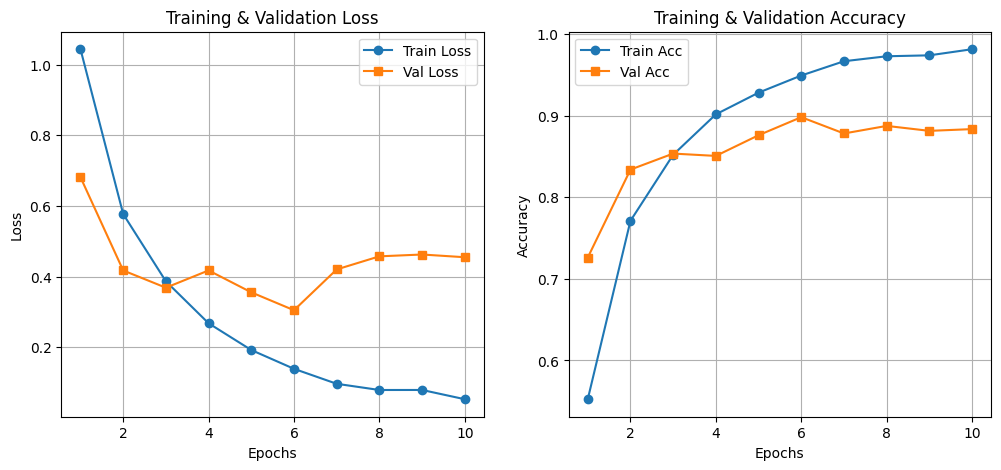

In [13]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Define CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, optimizer
model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
MODEL_SAVE_PATH = "models/simplecnn_oct8.pth"

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(train_loader), correct / total

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(val_loader), correct / total


EPOCHS = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc == max(val_accs):  # Best so far
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

print("\nTraining Complete - Best Validation Accuracy:", max(val_accs))
plot_curves(train_losses, val_losses, train_accs, val_accs)


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
from utils import *

DATA_DIR = "data/RetinalOCT_Dataset/"

# Define transformations for different preprocessing approaches
transform_raw = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_preprocessed1 = transforms.Compose([
    transforms.Resize((224, 224)),
    CLAHETransform(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_preprocessed2 = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    CannyEdgeTransform(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

DATA_DIR = "data/RetinalOCT_Dataset/"
OUTPUT_DIR = DATA_DIR + "/preprocessed_dataset/"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# # Process and save images
# for class_name in os.listdir(DATA_DIR + "train"):
#     class_path = os.path.join(DATA_DIR + "train", class_name)
#     output_class_path = os.path.join(OUTPUT_DIR+ "train", class_name)
    
#     if not os.path.exists(output_class_path):
#         os.makedirs(output_class_path)

#     for image_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
#         image_path = os.path.join(class_path, image_name)
        
#         try:
#             # Load and transform image
#             image = Image.open(image_path).convert("RGB")
#             image_raw = transform_raw(image)
#             image_p1 = transform_preprocessed1(image)
#             image_p2 = transform_preprocessed2(image)

#             # Concatenate along the channel dimension
#             concatenated_image = torch.cat([image_raw, image_p1, image_p2], dim=0)  # (9, 224, 224)

#             # Save as .pt file
#             output_path = os.path.join(output_class_path, image_name.replace(".jpeg", ".pt"))
#             torch.save(concatenated_image, output_path)
#         except Exception as e:
#             print(f"Error processing {image_path}: {e}")

# for class_name in os.listdir(DATA_DIR + "val"):
#     class_path = os.path.join(DATA_DIR + "val", class_name)
#     output_class_path = os.path.join(OUTPUT_DIR + "val", class_name)
    
#     if not os.path.exists(output_class_path):
#         os.makedirs(output_class_path)

#     for image_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
#         image_path = os.path.join(class_path, image_name)
        
#         try:
#             # Load and transform image
#             image = Image.open(image_path).convert("RGB")
#             image_raw = transform_raw(image)
#             image_p1 = transform_preprocessed1(image)
#             image_p2 = transform_preprocessed2(image)

#             # Concatenate along the channel dimension
#             concatenated_image = torch.cat([image_raw, image_p1, image_p2], dim=0)  # (9, 224, 224)

#             # Save as .pt file
#             output_path = os.path.join(output_class_path, image_name.replace(".jpeg", ".pt"))
#             torch.save(concatenated_image, output_path)
#         except Exception as e:
#             print(f"Error processing {image_path}: {e}")

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch

class PreprocessedOCTDataset(Dataset):
    def __init__(self, dataset_dir, class_to_idx):
        self.dataset_dir = dataset_dir
        self.class_to_idx = class_to_idx
        self.image_paths = []
        self.labels = []

        # Collect all preprocessed .pt files
        for class_name, class_idx in class_to_idx.items():
            class_path = os.path.join(dataset_dir, class_name)
            for image_file in os.listdir(class_path):
                if image_file.endswith(".jpg"): ## change to pt later
                    self.image_paths.append(os.path.join(class_path, image_file))
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_tensor = torch.load(self.image_paths[idx])  # Load preprocessed tensor
        label = self.labels[idx]
        return image_tensor, label

# Define class-to-index mapping
class_names = sorted(os.listdir(OUTPUT_DIR + "train"))  # Ensure order is consistent
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# Create dataset and DataLoader
dataset = PreprocessedOCTDataset(OUTPUT_DIR + "train", class_to_idx)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(PreprocessedOCTDataset(OUTPUT_DIR + "val", class_to_idx), batch_size=32, shuffle=False)

# Test a batch
for images, labels in train_loader:
    print("Batch shape:", images.shape)  # Should be (batch_size, 9, 224, 224)
    print("Labels:", labels)
    break


Batch shape: torch.Size([32, 9, 224, 224])
Labels: tensor([7, 1, 2, 5, 5, 5, 0, 3, 0, 5, 2, 7, 5, 4, 5, 0, 0, 5, 2, 0, 3, 1, 4, 0,
        1, 7, 0, 4, 5, 0, 4, 7])


100%|██████████| 88/88 [00:49<00:00,  1.78it/s]


Epoch 1/10 -> Train Acc: 0.4537 | Val Acc: 0.5514


100%|██████████| 88/88 [00:09<00:00,  8.90it/s]


Epoch 2/10 -> Train Acc: 0.6053 | Val Acc: 0.6525


100%|██████████| 88/88 [00:09<00:00,  9.14it/s]


Epoch 3/10 -> Train Acc: 0.7629 | Val Acc: 0.7375


100%|██████████| 88/88 [00:09<00:00,  8.89it/s]


Epoch 4/10 -> Train Acc: 0.8743 | Val Acc: 0.7482


100%|██████████| 88/88 [00:09<00:00,  9.20it/s]


Epoch 5/10 -> Train Acc: 0.9440 | Val Acc: 0.7304


100%|██████████| 88/88 [00:10<00:00,  8.79it/s]


Epoch 6/10 -> Train Acc: 0.9730 | Val Acc: 0.7493


100%|██████████| 88/88 [00:10<00:00,  8.59it/s]


Epoch 7/10 -> Train Acc: 0.9874 | Val Acc: 0.7321


100%|██████████| 88/88 [00:09<00:00,  8.91it/s]


Epoch 8/10 -> Train Acc: 0.9897 | Val Acc: 0.6861


100%|██████████| 88/88 [00:52<00:00,  1.69it/s]


Epoch 9/10 -> Train Acc: 0.9882 | Val Acc: 0.7361


100%|██████████| 88/88 [00:10<00:00,  8.50it/s]


Epoch 10/10 -> Train Acc: 0.9933 | Val Acc: 0.7325

Training Complete - Best Validation Accuracy: 0.7492857142857143


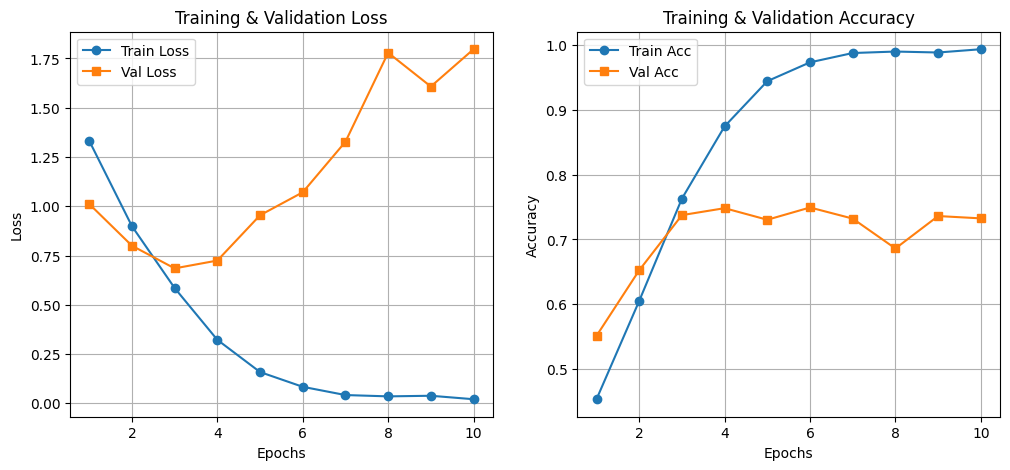

In [10]:
# 1.4s / it
class CustomCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(9, 32, kernel_size=3, padding=1)  # Change input channels to 9
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Adjust for feature map size
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Initialize model, loss function, optimizer
model = CustomCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
MODEL_SAVE_PATH = "models/customcnn_oct8.pth"


# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(train_loader), correct / total

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(val_loader), correct / total

EPOCHS = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc == max(val_accs):  # Best so far
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

print("\nTraining Complete - Best Validation Accuracy:", max(val_accs))
plot_curves(train_losses, val_losses, train_accs, val_accs)



100%|██████████| 88/88 [00:11<00:00,  7.48it/s]


Epoch 1/10 -> Train Acc: 0.5868 | Val Acc: 0.7136


100%|██████████| 88/88 [00:11<00:00,  7.60it/s]


Epoch 2/10 -> Train Acc: 0.8129 | Val Acc: 0.8321


100%|██████████| 88/88 [00:11<00:00,  7.56it/s]


Epoch 3/10 -> Train Acc: 0.9184 | Val Acc: 0.8343


100%|██████████| 88/88 [00:11<00:00,  7.49it/s]


Epoch 4/10 -> Train Acc: 0.9609 | Val Acc: 0.8068


100%|██████████| 88/88 [00:11<00:00,  7.45it/s]


Epoch 5/10 -> Train Acc: 0.9809 | Val Acc: 0.8321


100%|██████████| 88/88 [00:11<00:00,  7.58it/s]


Epoch 6/10 -> Train Acc: 0.9854 | Val Acc: 0.8189


100%|██████████| 88/88 [00:11<00:00,  7.61it/s]


Epoch 7/10 -> Train Acc: 0.9846 | Val Acc: 0.8039


100%|██████████| 88/88 [00:11<00:00,  7.56it/s]


Epoch 8/10 -> Train Acc: 0.9882 | Val Acc: 0.8164


100%|██████████| 88/88 [00:11<00:00,  7.60it/s]


Epoch 9/10 -> Train Acc: 0.9883 | Val Acc: 0.7754


100%|██████████| 88/88 [00:11<00:00,  7.55it/s]


Epoch 10/10 -> Train Acc: 0.9902 | Val Acc: 0.8150

Training Complete - Best Validation Accuracy: 0.8342857142857143


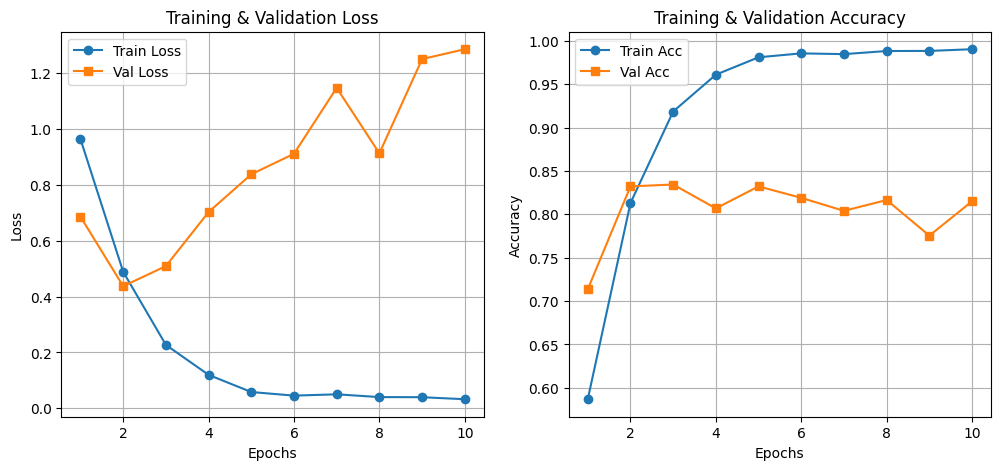

In [ ]:
# 2.55s / it

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from utils import *
from PIL import Image
from torchvision.transforms.functional import to_pil_image

MODEL_SAVE_PATH = "models/multicnn_oct8.pth" # add method name and model name and common model path - make modular
NUM_CLASSES = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10

# Base CNN Model (Without Last Layer)
class BaseCNN(nn.Module):
    def __init__(self, output_features=512):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  
        x = self.relu(self.fc1(x))  # 512-Dimensional Embedding
        return x

# Multi-Stream CNN Model
class MultiStreamCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(MultiStreamCNN, self).__init__()
        self.cnn1 = BaseCNN()  
        self.cnn2 = BaseCNN() 
        self.cnn3 = BaseCNN()  

        self.fc1 = nn.Linear(512 * 3, 512)  # Concatenated embeddings
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, img_raw, img_p1, img_p2):
        feat1 = self.cnn1(img_raw)
        feat2 = self.cnn2(img_p1)
        feat3 = self.cnn3(img_p2)

        combined_feat = torch.cat((feat1, feat2, feat3), dim=1)  # Concatenation

        x = self.relu(self.fc1(combined_feat))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Initialize model, loss, optimizer
model = MultiStreamCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in tqdm(train_loader):
        # Extract different pre processed image from concatenated image
        img_raw = torch.stack([img[:3, :, :] for img in images]).to(device)
        img_p1 = torch.stack([img[3:6, :, :] for img in images]).to(device)
        img_p2 = torch.stack([img[6:9, :, :] for img in images]).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(img_raw, img_p1, img_p2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(train_loader), correct / total

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            img_raw = torch.stack([img[:3, :, :] for img in images]).to(device)
            img_p1 = torch.stack([img[3:6, :, :] for img in images]).to(device)
            img_p2 = torch.stack([img[6:9, :, :] for img in images]).to(device)
            labels = labels.to(device)

            outputs = model(img_raw, img_p1, img_p2)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(val_loader), correct / total

# Track loss & accuracy
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc == max(val_accs):
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

print("\nTraining Complete - Best Validation Accuracy:", max(val_accs))
plot_curves(train_losses, val_losses, train_accs, val_accs)


test set and test image processing, time taken 25 - 30 mins

convert to single channel !!!

### Densenet / resnet  -check comparison paper

### Extra

In [ ]:
# class_weights = torch.tensor([1.0, 1.2, 1.5, 1.3]).to(device)  # Adjust based on class frequencies
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# from sklearn.utils.class_weight import compute_class_weight

# # Assuming `train_dataset` is an ImageFolder dataset
# class_counts = [len(np.where(np.array(train_dataset.targets) == i)[0]) for i in range(len(train_dataset.classes))]

# # Compute class weights: (Inverse of frequency)
# class_weights = compute_class_weight('balanced', classes=np.arange(len(class_counts)), y=np.array(train_dataset.targets))
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# # Use the weights in CrossEntropyLoss
# criterion = nn.CrossEntropyLoss(weight=class_weights)



In [4]:
import numpy as np

from tqdm import tqdm
for epoch in (range(num_epochs)):
    # Training phase
    resnet50.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    epoch_acc = correct_train / total_train
    torch.save(resnet50.state_dict(), "resnet50_finetuned.pth")

    # Validation phase
    resnet50.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for _, (inputs, labels) in tqdm(enumerate(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(test_dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_acc = correct_val / total_val

    print(f"Epoch [{epoch + 1}/{num_epochs}]"
          f" Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}"
          f" Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")



  5%|▌         | 1/20 [1:24:08<26:38:44, 5048.67s/it]

Epoch [1/20] Train Loss: 0.5529, Train Acc: 0.8092 Val Loss: 0.4728, Val Acc: 0.7656


 10%|█         | 2/20 [2:58:21<27:01:08, 5403.78s/it]

Epoch [2/20] Train Loss: 0.4897, Train Acc: 0.8311 Val Loss: 0.4533, Val Acc: 0.8063


 15%|█▌        | 3/20 [4:26:19<25:14:49, 5346.43s/it]

Epoch [3/20] Train Loss: 0.4654, Train Acc: 0.8404 Val Loss: 0.5288, Val Acc: 0.7625


 20%|██        | 4/20 [6:08:02<25:05:23, 5645.20s/it]

Epoch [4/20] Train Loss: 0.4520, Train Acc: 0.8444 Val Loss: 0.4653, Val Acc: 0.8000


 25%|██▌       | 5/20 [7:49:41<24:12:15, 5809.02s/it]

Epoch [5/20] Train Loss: 0.4458, Train Acc: 0.8462 Val Loss: 0.5815, Val Acc: 0.7365


 30%|███       | 6/20 [9:31:32<22:59:22, 5911.58s/it]

Epoch [6/20] Train Loss: 0.4320, Train Acc: 0.8510 Val Loss: 0.5072, Val Acc: 0.7604


 35%|███▌      | 7/20 [11:13:35<21:35:49, 5980.74s/it]

Epoch [7/20] Train Loss: 0.4284, Train Acc: 0.8524 Val Loss: 0.5392, Val Acc: 0.7656


 35%|███▌      | 7/20 [12:40:19<23:32:02, 6517.10s/it]


KeyboardInterrupt: 